### Import Reuqired Libraries

In [1]:
import gzip
import random
from collections import defaultdict
from random import sample
import pandas as pd
import numpy as np
import math

### Read the dataset

In [2]:
dataDir = "Your drive location"

path = dataDir+ "trainInteractions.csv.gz"
rating_dataset = []
for i in gzip.open(path, 'rt', encoding="utf8"):
    rating_dataset.append(i.strip().split(','))

### Split the data into train and test

In [3]:
train_dataset = rating_dataset[1:400001]
test_dataset = rating_dataset[400001:500001]

In [4]:
train_dataset_dict= []
for i in train_dataset:
    train_dataset_dict.append({'user_id':i[0],'recipe_id':i[1],'date':i[2], 'rating':float(i[3])})

test_dataset_dict= []
for i in test_dataset:
    test_dataset_dict.append({'user_id':i[0],'recipe_id':i[1],'date':i[2], 'rating':float(i[3])})    

### Extract datastructures which can be used for further analysis

In [5]:
def extract_datastructures(dataset, user_column, item_column, rating_column):
    users_per_item = defaultdict(set)            # Maps an item to the users who rated it
    items_per_user = defaultdict(set)            # Maps a user to the items that they rated
    rating_dict = {}                             # To retrieve a rating for a specific user/item pair
    detailsPerUser = defaultdict(list)           # Maps a user to all details
    detailsPerItem = defaultdict(list)           # Maps an item to all details
    user_averages = {}                           # store the average rating by each user
    item_averages = {}                           # store the average rating for every item

    for d in dataset:
        user,item = d[user_column], d[item_column]
        users_per_item[item].add(user)
        items_per_user[user].add(item)
        rating_dict[(user,item)] = d[rating_column]
        
    for d in dataset:
        user,item = d[user_column], d[item_column]
        detailsPerUser[user].append((d[item_column],d[rating_column]))
        detailsPerItem[item].append((d[user_column],d[rating_column]))
        
    for u in items_per_user:
        rs = [rating_dict[(u,i)] for i in items_per_user[u]]
        user_averages[u] = sum(rs) / len(rs)

    for i in users_per_item:
        rs = [rating_dict[(u,i)] for u in users_per_item[i]]
        item_averages[i] = sum(rs) / len(rs)
    
    return users_per_item, items_per_user, detailsPerUser, detailsPerItem, rating_dict, user_averages, item_averages

In [6]:
users_per_recipe_tr, recipes_per_user_tr, detailsPerUser_tr, detailsPerRecipe_tr, rating_dict_tr, user_averages_tr, recipe_averages_tr  = extract_datastructures(train_dataset_dict,'user_id','recipe_id','rating')
users_per_recipe_ts, recipes_per_user_ts, detailsPerUser_ts, detailsPerRecipe_ts, rating_dict_ts, user_averages_ts, recipe_averages_ts  = extract_datastructures(test_dataset_dict,'user_id','recipe_id','rating')

### Trivial model

In [7]:
average_rating = np.mean([i['rating'] for i in train_dataset_dict])

In [8]:
trivial_mse = 0
for i in test_dataset_dict:
    r = float(i['rating'])
    se = (r - average_rating)**2
    trivial_mse += se

trivial_mse /= len(test_dataset_dict)
print("trivial MSE on test data: " + str(trivial_mse))

trivial MSE on test data: 0.9095362079996616


### Initialize biases for user and item

In [9]:
beta_user = {}
beta_recipe = {}
for u in user_averages_tr:
    beta_user[u] = 0

for r in recipe_averages_tr:
    beta_recipe[r] = 0

In [10]:
gamma_user = {}
gamma_item = {}
K=7
for u in user_averages_tr:
    gamma_user[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
    
for i in recipe_averages_tr:
    gamma_item[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

### Define functions for further analysis
Function used to calculate rating:- 
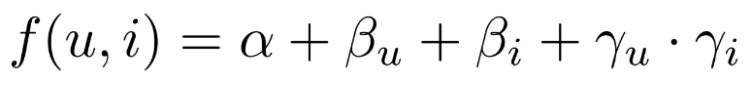

In [11]:
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

In [12]:
#### This function will help us calculate alpha, betas and gammas by updating them ####
def iterate(lambU, lambI):
    
    alpha_ = 0  # This will help update alpha
    
    # Updating alpha 
    for data in train_dataset_dict:
        r = float(data['rating'])
        u = data['user_id']
        b = data['recipe_id']
        alpha_ += r - (beta_user[u] + beta_recipe[b]) - inner(gamma_user[u], gamma_item[b])
    alpha = alpha_ / len(train_dataset_dict)
    
    # updated the bias of user
    for u in detailsPerUser_tr:
        beta_user_new = 0
        for b,r in detailsPerUser_tr[u]:
            beta_user_new += r - (alpha + beta_recipe[b]) - inner(gamma_user[u], gamma_item[b])
        beta_user[u] = beta_user_new / (lambU + len(detailsPerUser_tr[u]))
    
    # updated the bias of item
    for b in detailsPerRecipe_tr:
        beta_item_new = 0
        for u,r in detailsPerRecipe_tr[b]:
            beta_item_new += r - (alpha + beta_user[u]) - inner(gamma_user[u], gamma_item[b])
        beta_recipe[b] = beta_item_new / (lambI + len(detailsPerRecipe_tr[b]))
    
    # updated the latent interaction matrix of item
    for b in detailsPerRecipe_tr:
        gamma_item_new = [0.0 for k in range(K)]
        for k in range(K):
            for u,r in detailsPerRecipe_tr[b]:
                gamma_item_new[k] += (r - (alpha + beta_user[u] + beta_recipe[b]))*gamma_user[u][k]
            gamma_item[b][k] = gamma_item_new[k]/(lambI + len(detailsPerRecipe_tr[b]))

    # updated the latent interaction matrix of user
    for u in detailsPerUser_tr:
        gamma_user_new = [0.0 for k in range(K)]
        for k in range(K):
            for b,r in detailsPerUser_tr[u]:
                gamma_user_new[k] += (r - (alpha + beta_user[u] + beta_recipe[b]))*gamma_item[b][k]
            gamma_user[u][k] = gamma_user_new[k]/(lambU + len(detailsPerUser_tr[u]))

    mse = 0
    
    # updated the regularizer
    for data in train_dataset_dict:
        r = float(data['rating'])
        u = data['user_id']
        b = data['recipe_id']
        prediction = alpha + beta_user[u] + beta_recipe[b] + inner(gamma_user[u], gamma_item[b])
        mse += (r - prediction)**2
    regularizer = 0
    for u in beta_user:
        regularizer += lambU*beta_user[u]**2
        for k in range(K):
            regularizer += lambU*gamma_user[u][k]**2
    for b in beta_recipe:
        regularizer += lambI*beta_recipe[b]**2
        for k in range(K):
            regularizer += lambI*gamma_item[b][k]**2
    mse /= len(train_dataset_dict)
    
    return mse, mse + regularizer, alpha

In [ ]:
save = [] # To store the latent factor, lambdas and RMSE

# intialize the iteration function
iterations = 1
alpha = average_rating 
newMSE,newObjective,alph = iterate(1,1)

for K in range(4,10):
    for lamb_u in range(5,20):
        for lamb_i in range(5,20):
            iterations = 1
            beta_user = {}
            beta_recipe = {}
            for u in user_averages_tr:
                beta_user[u] = 0

            for r in recipe_averages_tr:
                beta_recipe[r] = 0
        
            gamma_user = {}
            gamma_item = {}

            for u in user_averages_tr:
                gamma_user[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
        
            for i in recipe_averages_tr:
                gamma_item[i] = [random.random() * 0.1 - 0.05 for k in range(K)]
        
            while iterations < 20 or objective - newObjective > 0.0001:
                mse, objective,alp = newMSE, newObjective,alph
                newMSE, newObjective,alph = iterate(lamb_u,lamb_i)
                iterations += 1
                
                validation_MSE = 0
                for d in test_dataset_dict:
                    r = int(d['rating'])
                    bu = 0
                    bi = 0
                    gamma = 0
                    if d['user_id'] in beta_user:
                        bu = beta_user[d['user_id']]
                    if d['recipe_id'] in beta_recipe:
                        bi = beta_recipe[d['recipe_id']]
                    if d['user_id'] in gamma_user:
                        gamma_u = gamma_user[d['user_id']]
                    if d['recipe_id'] in gamma_item:
                        gamma_i = gamma_item[d['recipe_id']]
                
                    prediction = alph + bu + bi + inner(gamma_u, gamma_i)
                    validation_MSE += (r - prediction)**2

                validation_MSE /= len(test_dataset_dict)
                    
                save.append([K,lamb_u,lamb_i,validation_MSE])